In [ ]:
# library import
from matplotlib.ticker import FixedLocator, FixedFormatter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split 
import statsmodels as sm
import statsmodels.api as sma
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as smgt
import seaborn as sns
import math

In [ ]:
# custom import
from utilities import *
from BLAS import *
from feature_eng import *
from trans_cost import *

# Table of Contents <a class="anchor" id="toc"></a>
[Data Preparation](#first)

[Baseline - SVM](#second)

[DL Models](#third)
* [Base Model: CNN-LSTM with Open Price Data](#cnnlstm)
* [Base Model: CNN-LSTM with Open Price Data & Thresholds](#tsd)
* [Base Model: Hyperparameter Tuning](#ht)
* [Base Model: More Layers](#layers)
* [Base Model: Rolling Horizon](#rh)
* [Advanced Model - External Data](#ed)

# Data Preparation <a class="anchor" id="first"></a>

[Back to Top](#toc)

BLAS.py has the following functions that transform the raw data to model inputs:

- create_dataset
- getLogData
- getData
- ConstructFirstDifferencesData
- EvaluateModel
- ClassificationEvaluation
- AutoCorrelationResidual_Test
- TestForResidualCorrelation

feature_eng.py has the following functions that help in EDA procedure:

- price_pattern: calculated open price related features
- ADF_test
- standard_average

## 1) Original data using Binance API

In [ ]:
old_BTC = pd.read_csv('/home/jupyter/data_binance/BTC_USD_1h_old.csv').iloc[:,2:]
old_BTC['time'] = pd.to_datetime(old_BTC.timestamp).dt.strftime('%Y-%m-%d %H')
old_BTC['date'] = pd.to_datetime(old_BTC.timestamp).dt.strftime('%Y-%m-%d')
old_BTC.describe()

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
count,26170.000000,26170.000000,26170.000000,26170.000000,26170.000000,2.617000e+04,2.617000e+04,26170.000000,26170.000000,2.617000e+04,26170.000000
mean,7746.073493,7793.789634,7694.324198,7746.344935,1740.998912,1.550286e+12,1.383537e+07,14731.119832,876.504472,6.943763e+06,2320.267407
std,2690.965241,2720.603596,2656.912319,2690.970623,1989.928302,2.731152e+10,1.637609e+07,15096.157788,976.293749,8.053483e+06,8290.852170
min,2870.900000,2950.000000,2817.000000,2919.000000,0.000000,1.502946e+12,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
25%,6198.147500,6240.160000,6154.295000,6198.147500,735.467057,1.526642e+12,4.962338e+06,6086.250000,377.938015,2.547889e+06,0.000000
50%,7646.465000,7687.895000,7608.195000,7646.340000,1250.984559,1.550295e+12,9.576093e+06,10579.000000,645.652376,4.953114e+06,0.000000
75%,9373.247500,9410.000000,9328.042500,9374.162500,2074.089528,1.573941e+12,1.692127e+07,18840.000000,1054.997596,8.477961e+06,0.000000
max,19709.500000,19798.680000,19552.000000,19709.500000,47255.762685,1.597532e+12,4.139864e+08,327193.000000,20628.794047,1.832529e+08,79920.622111


#### From the plot below, we see that the Most of the TOP 100 trading volume appeared in COVID-19 period. Bitcoin transaction is quiet active during the COVID-19 periods.

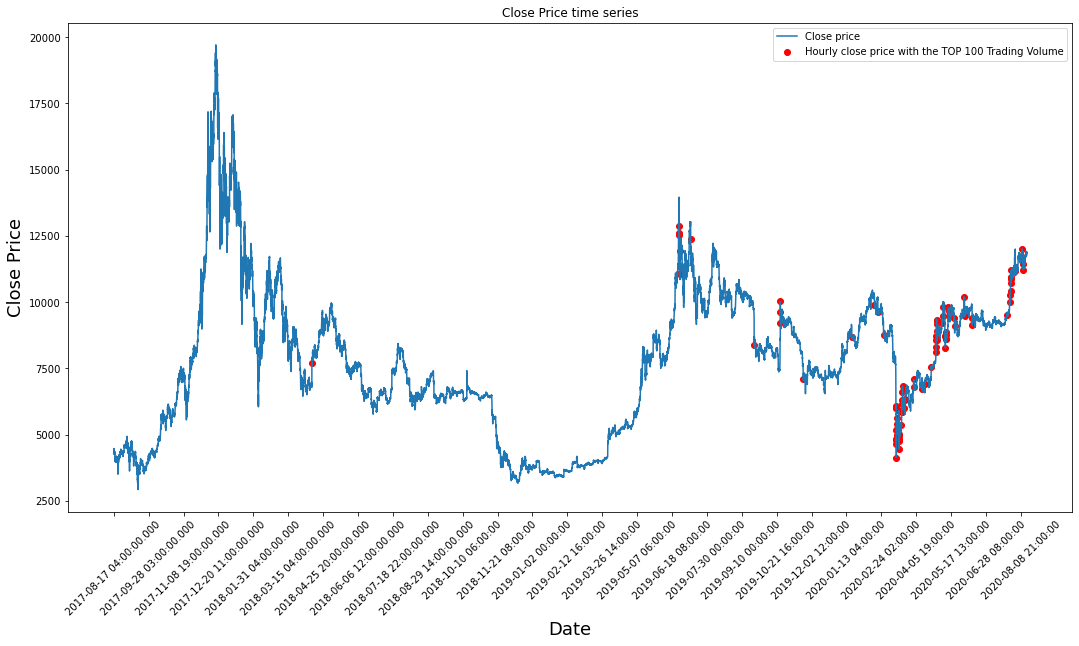

In [ ]:
max_vol_index = list(old_BTC['trades'].nlargest(100).index)
plt.figure(figsize = (18,9))
plt.plot(range(old_BTC.shape[0]),old_BTC['close'])
plt.scatter(max_vol_index, old_BTC.loc[max_vol_index]['close'].values, color = 'red')
n = np.arange(1,101)
#for i, txt in enumerate(n):
#    plt.annotate(txt, (max_vol_index[i], btcdf.loc[max_vol_index]['close'].values[i]))
    
plt.xticks(range(0,old_BTC.shape[0],1000),old_BTC['timestamp'].loc[::1000],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.title('Close Price time series')
plt.legend(['Close price', 'Hourly close price with the TOP 100 Trading Volume'])
plt.show()

### Find missing values

We found that there are multiply missing values, some of them are consecutive missing values. We proposed 3 solutions:
1. Try interpolation
2. Try simple rolling average
3. Find other API to backfill

In [ ]:
d = pd.to_datetime(old_BTC.date)
df = pd.DataFrame(pd.date_range(start = d[0], end = d[len(d)-1],freq='H'),columns= ['timestamp'])
old_BTC['timestamp'] = pd.to_datetime(old_BTC.timestamp)
new = df.merge(old_BTC,on=['timestamp'],how='outer').fillna(0)
missing_value = pd.DataFrame(list(new.timestamp[new['open'] == 0][4:]), columns = ['Date'])
missing_value['Day'] = list(new.timestamp[new['open'] == 0][4:].dt.strftime('%Y-%m-%d'))
miss = missing_value.groupby('Day').count()
miss.columns = ['Count']
miss

,Count
Day,
2017-09-06,7
2018-01-04,1
2018-02-08,23
2018-02-09,24
2018-02-10,24
2018-02-11,4
2018-06-26,10
2018-06-27,1
2018-07-04,7


#### - Interpolation

In [ ]:
fulfill = df.merge(old_BTC,on=['timestamp'],how='outer').loc[4:].reset_index()
fulfill.drop(fulfill.columns[0], axis = 1, inplace = True)
#fulfill.set_index(fulfill.timestamp.values, inplace = True)
interp = fulfill['open'].interpolate(method='linear')
result = pd.DataFrame()
result['True'] = fulfill['open'].values
result['Interpolation'] = interp.values

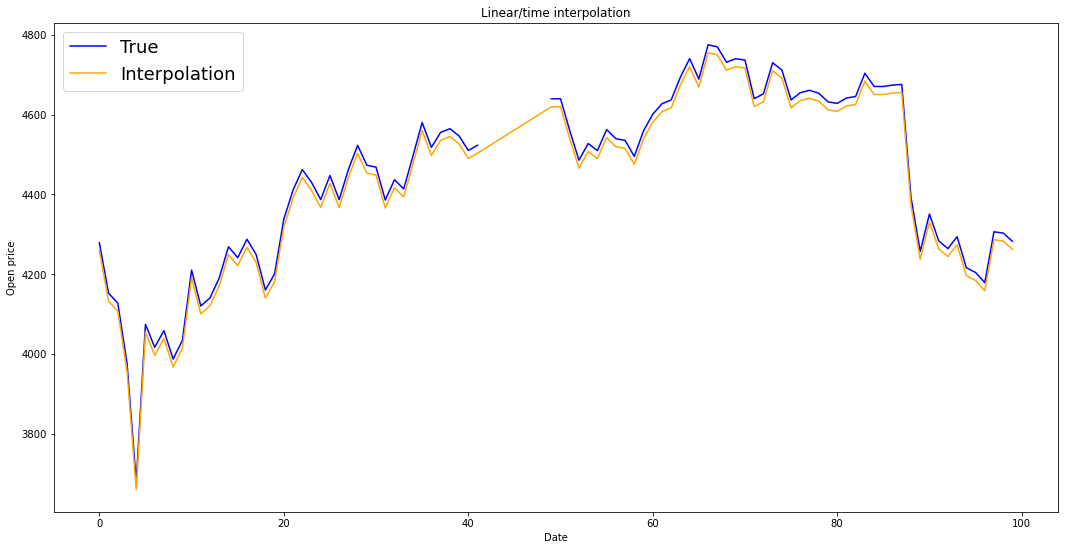

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(fulfill.shape[0])[:100],fulfill.loc[450:549]['open']+ 20,color='b', label='True')
plt.plot(range(fulfill.shape[0])[:100],interp.values[450:550],color='orange', label='Interpolation')
plt.xlabel('Date')
plt.ylabel('Open price')
plt.legend(fontsize=18)
plt.title('Linear/time interpolation')
plt.show()

#### - Rolling average

In [ ]:
window_size = 3
N = len(fulfill)
std_avg_predictions = []
std_avg_x = []
mse_errors = []
attempt = fulfill.copy()

for pred_idx in range(window_size,N):
    predict = np.mean(attempt[pred_idx-window_size:pred_idx]['open'])
    if (math.isnan(attempt.open[pred_idx])):
        attempt.at[pred_idx, 'open'] = predict
            
    std_avg_predictions.append(predict)

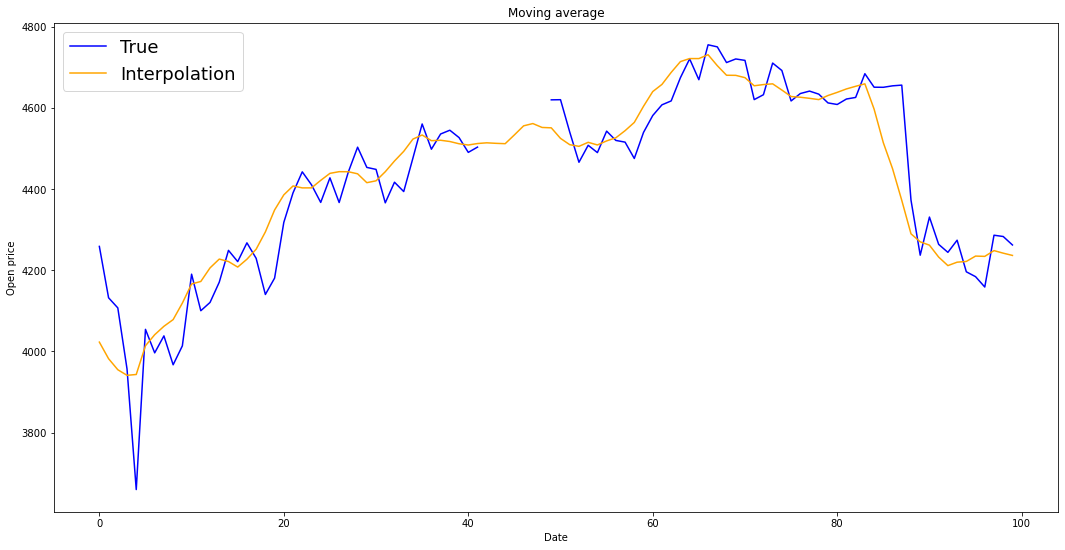

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(fulfill.shape[0])[:100],fulfill.loc[450:549]['open'],color='b',label='True')
plt.plot(range(fulfill.shape[0])[:100],std_avg_predictions[450:550],color='orange',label='Interpolation')
plt.xlabel('Date')
plt.ylabel('Open price')
plt.legend(fontsize=18)
plt.title('Moving average')
plt.show()

#### Both of the methods not perform well. Fortunately, we found a new dataset which has no missing values from Bitstamp. We perform analysis based on the new dataset in the next section.

## 2) New Data import and Feature engineering
#### New data source: Bistamp
The "price_pattern" function which is used to calculate extra features is included in feature_eng.py

In [ ]:
# import data
dat = pd.read_csv(r'../BTC_USD_1h.csv') # BTC related information
feature_dat = pd.read_csv(r'../all_features.csv') ## external factors 

In [ ]:
# add more price-pattern related features such as momentum, max drawdown, realized volatility
dat_update = price_pattern(dat)
final = dat_update.join(feature_dat)
final.to_csv('all_features_combine_Open.csv')
final.head()

,Timestamp,Open,High,Low,Close,first_diff,diff_threthold,pct_change_close,target,Volume_BTC,...,hash_rate,flag_before,Realize_Vol,RS,RSI,Stochastic_Oscillator,Stochastic_Oscillator_SMA,Bollinger_Low,Bollinger_High,Bollinger_Spread
1,2017-01-01 02:00:00,963.74,964.99,963.74,964.76,0.72,0.72,0.000748,1.0,26.484784,...,2.447999e+17,0,9.907156,1.948308,66.082244,0.702703,0.685956,0.014291,0.006269,0.020560
2,2017-01-01 03:00:00,964.91,964.98,964.88,964.96,1.17,1.89,0.001214,1.0,6.354253,...,2.447999e+17,0,8.207339,1.745301,63.574118,0.765928,0.654569,0.014718,0.005294,0.020012
3,2017-01-01 04:00:00,964.96,964.99,964.96,964.98,0.05,1.94,0.000052,1.0,30.983204,...,2.447999e+17,0,6.474071,1.524436,60.387193,0.726210,0.730728,0.013652,0.005383,0.019035
4,2017-01-01 05:00:00,964.98,965.62,964.98,965.60,0.02,1.96,0.000021,1.0,49.197639,...,2.447999e+17,0,3.393394,0.941729,48.499516,0.729549,0.731614,0.011877,0.004998,0.016875
5,2017-01-01 06:00:00,965.01,974.77,965.01,973.98,0.03,1.99,0.000031,1.0,344.930577,...,2.447999e+17,0,0.792966,1.273764,56.020067,0.734558,0.740563,0.010392,0.004671,0.015064


### Data analysis

#### 1) Unit root test

Let's first test whether there is a unit root for close price. Close price is non-stationary and follows a random walk process. 

The ADF tests suggest that we may not be able to reject the null that there is a unit-root for close price process, but we it indicates we are able to reject the null of having a unit-root after first differencing the data.

And we have the same issues for other time series rate such as exchange rate and indexes. Thus as the inputs, we use the first differencing of these rate.

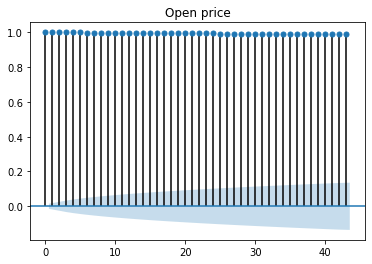

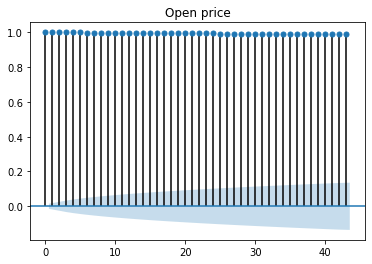

In [ ]:
sma.graphics.tsa.plot_acf(final.Open, title='Open price')

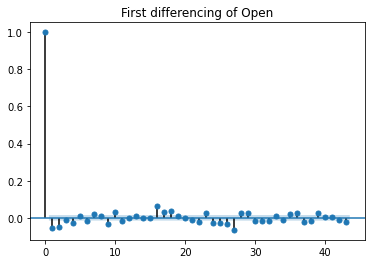

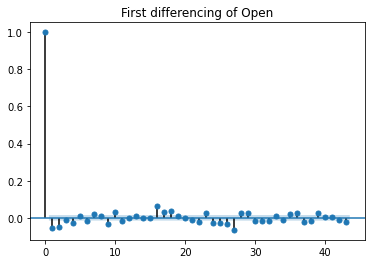

In [ ]:
sma.graphics.tsa.plot_acf(final.Open.diff().dropna(), title='First differencing of Open')

In [ ]:
print("ADF test on Open price:")
ADF_test(final.Open)
print("ADF test first diff of Open:")
ADF_test(final.Open.diff().dropna())

ADF test on Open price:
Close price: ADF statistic (p-value): -1.605 (0.481) 
	critical values {'1%': -3.430724221017473, '5%': -2.861705391222312, '10%': -2.566858033456859} 

ADF test first diff of Open:
Close price: ADF statistic (p-value): -19.871 (0.000) 
	critical values {'1%': -3.43072430669847, '5%': -2.861705429087613, '10%': -2.566858053611991} 



#### 2) Covariance/Correlation

#### - Exchange rate and BTC Open price

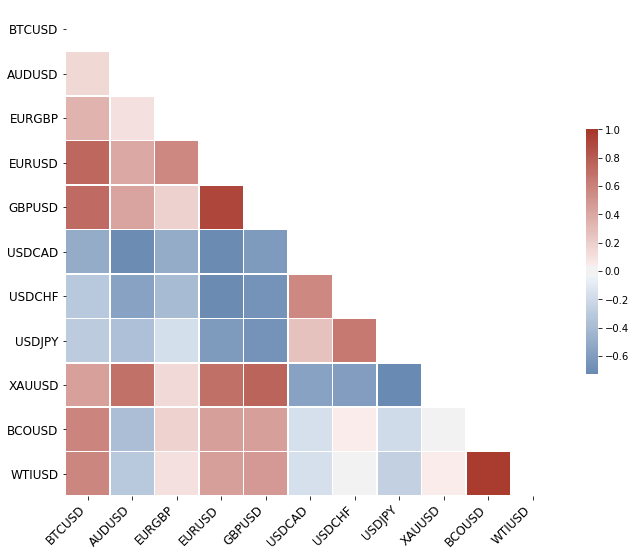

In [47]:
## Heat map  --  CURRENCY AND COMMO

f, ax = plt.subplots(figsize=(11, 9))

cols = ['Open'] + list(btcdf.columns[10:21])
corr = btcdf[cols].corr()

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, vmax=1, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right',fontsize=12)
plt.show()

#### - Indexes and BTC Open price

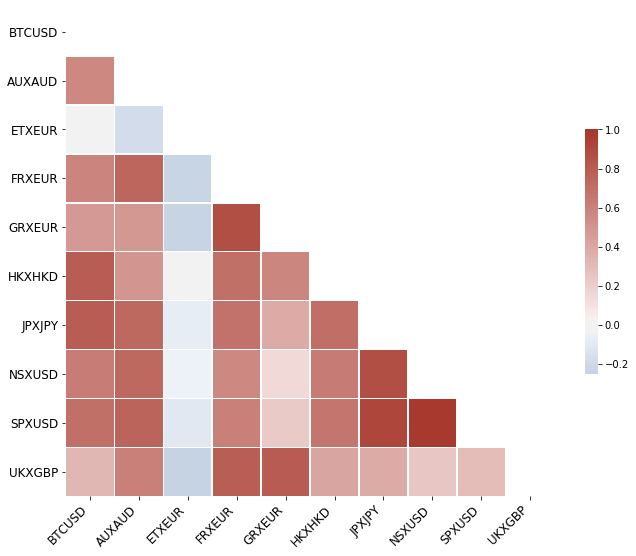

In [39]:
## Heat map  --  INDICES

f, ax = plt.subplots(figsize=(11, 9))

cols = ['Open'] + list(btcdf.columns[21:30])
corr = btcdf[cols].corr()

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, vmax=1, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize = 12)
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize = 12)
plt.show()

#### - Other factors and BTC Open price

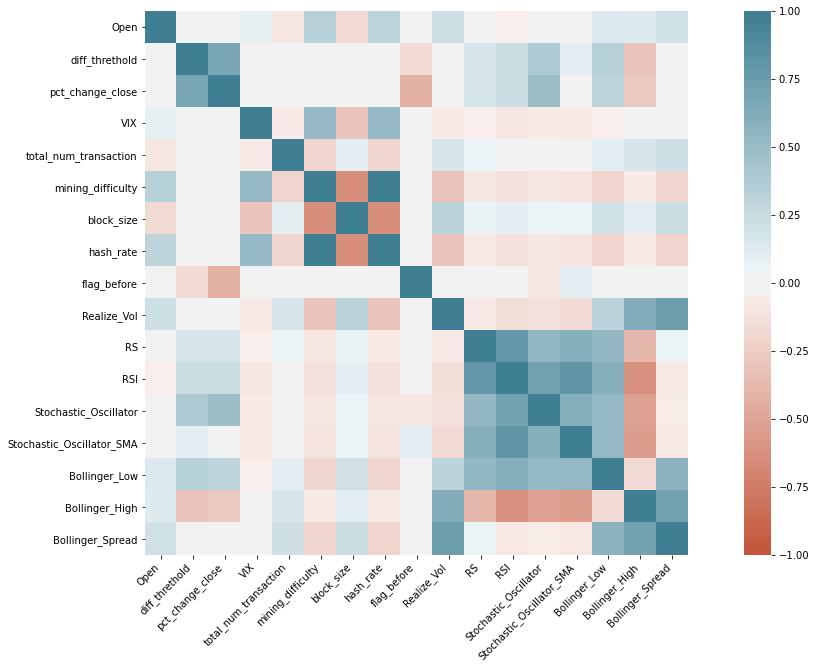

In [ ]:
plt.figure(figsize=(20,10))

cols = ['Open', 'diff_threthold', 'pct_change_close'] + list(btcdf.columns[30:])
corr = btcdf[cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### - Quick overview on the returns dispersion among our FX rates and Indices.

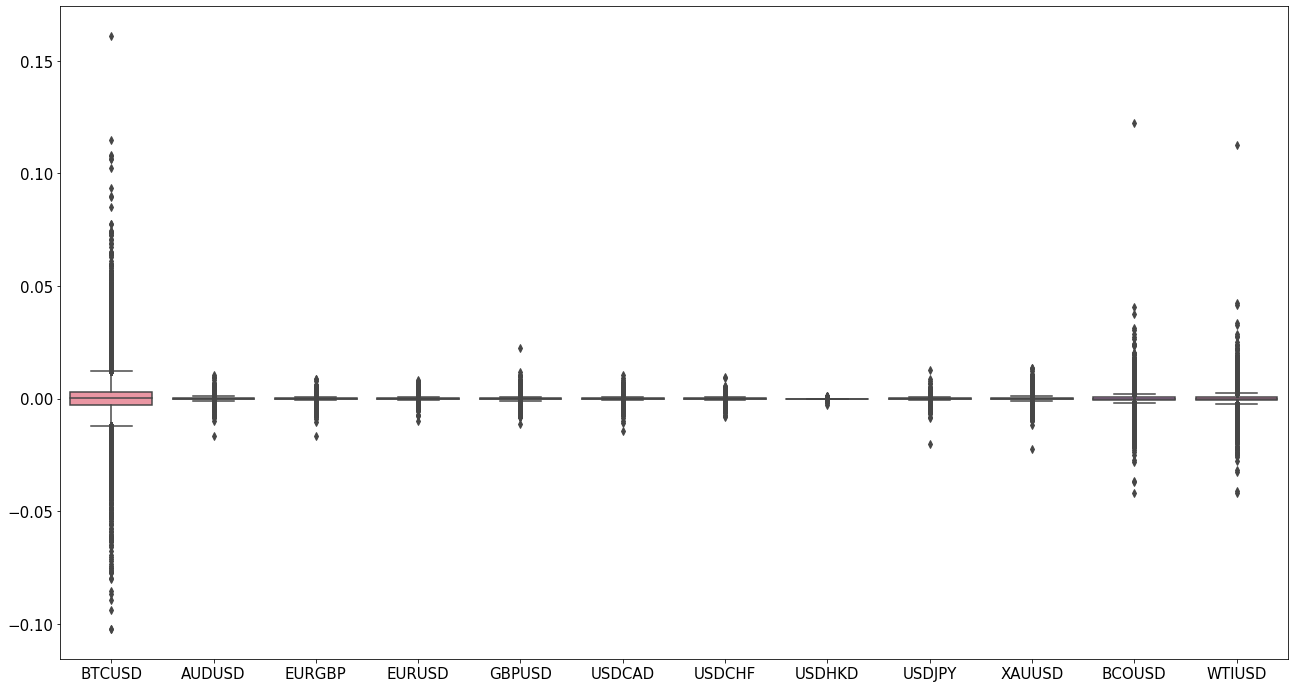

In [142]:
## FX rates -- Dispersion of the returns

fig, ax = plt.subplots(figsize=(22, 12))
ax.tick_params(labelsize=15)
cols = ['Open'] + list(btcdf.columns[10:21])
ALL_delta = btcdf[cols]
ax = sns.boxplot(data = ALL_delta)


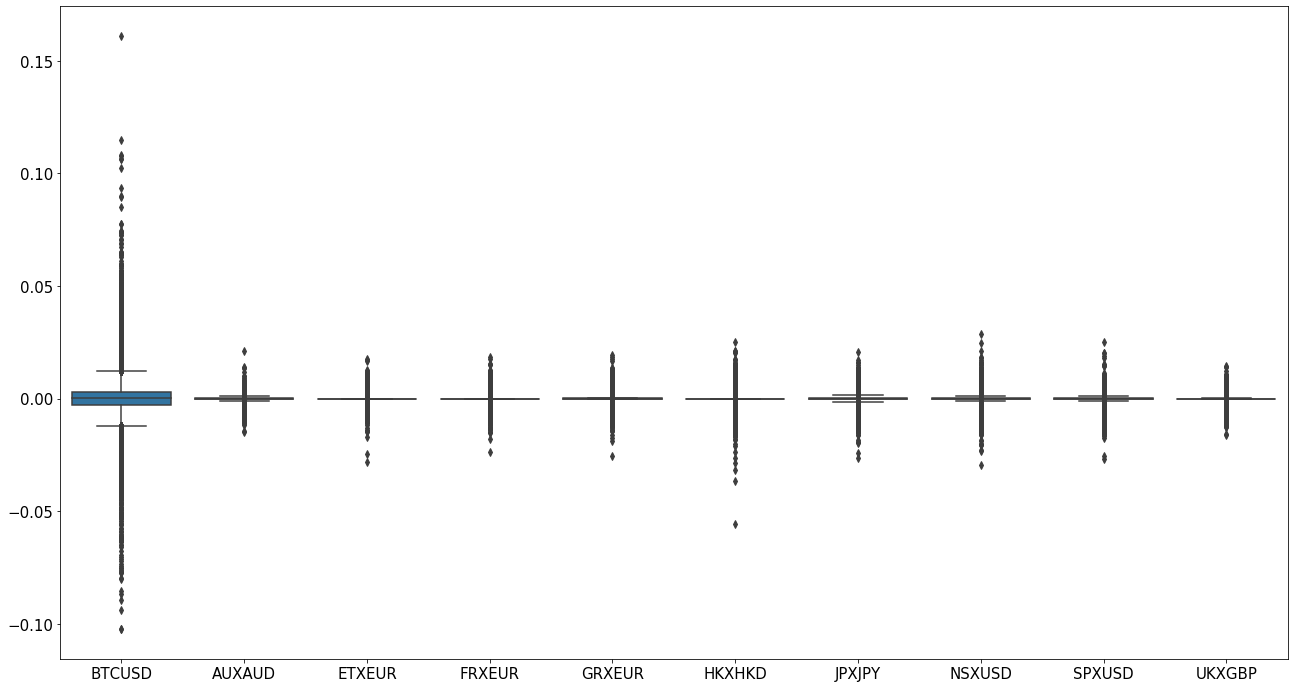

In [162]:
## Indices -- Dispersion of the returns

fig, ax = plt.subplots(figsize=(22, 12))
ax.tick_params(labelsize=15)
cols = ['Open'] + list(btcdf.columns[21:30])
ALL_delta = btcdf[cols]
ax = sns.boxplot(data = ALL_delta)

#### 3) Check y-label balance
From the bar chart, we see that the y-label is balanced, Up with 51.7\% and down with 48.3\%.

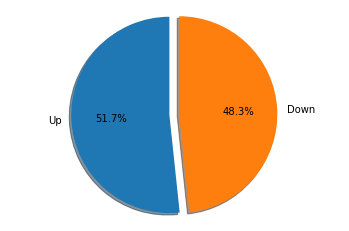

In [ ]:
labels = ['Up', 'Down']
sizes = [len(final[final.target == 1]), len(final[final.target == -1])]
explode = (0, 0.1)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 

plt.show()

#### 4) Simple average model for price prediction

Before doing any fancier prediction algorithms, we could see how normal averaging works. In other words, prediction at t+1 is the average value of all the prices you observed within a window of t to  t−N
Based on the previous plots, we see that:
1. it is not too bad of a model for very short predictions using normal average model
2. The larger the time window is, the larger MSE error, worse prediction performance

Note: The "standard_average" function is included in feature_eng.py


MSE error for standard averaging: 8086.74558


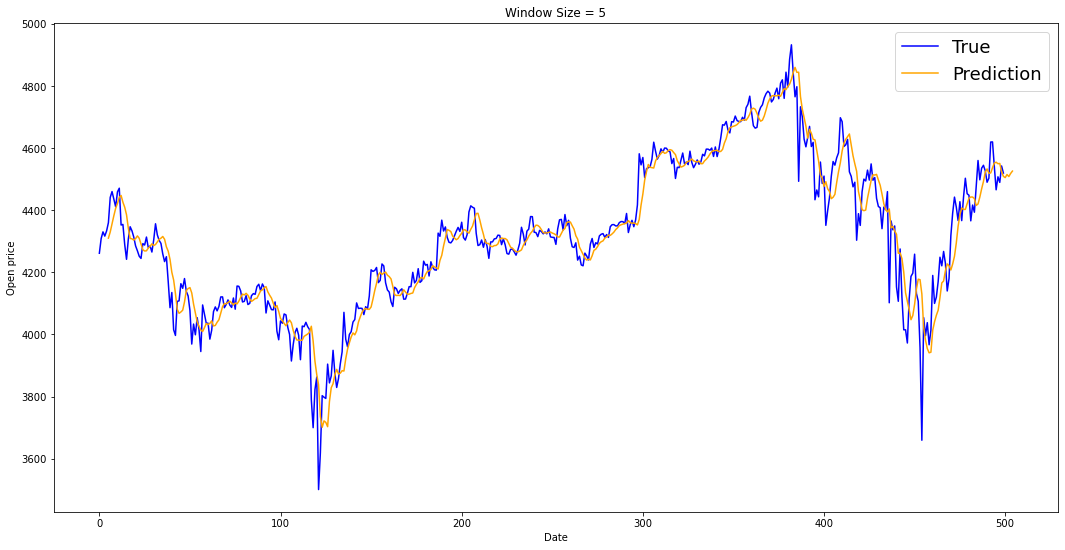

In [ ]:
standard_average(5, old_BTC)

MSE error for standard averaging: 14922.24766


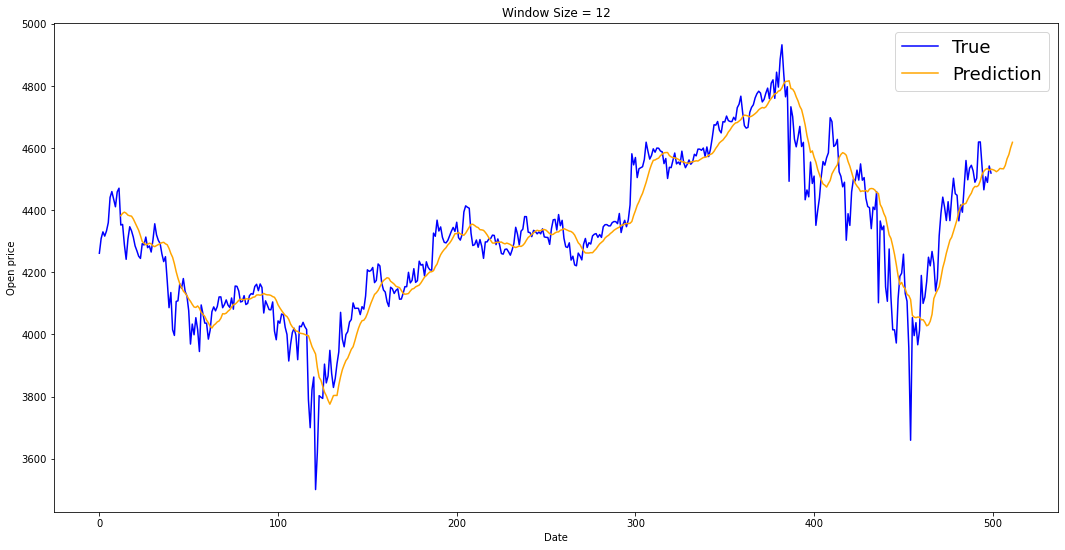

In [ ]:
standard_average(12, old_BTC)

# Baseline - SVM <a class="anchor" id="second"></a>

[Back to Top](#toc)

In [ ]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
btcdf = pd.read_csv(r'../all_features_combine.csv')
btcdf=btcdf.dropna()
X=btcdf[['Open']]
y1 = btcdf.target.astype(np.int8)
np.unique(y1)
y=y1.shift(-1)[:-1]
X_train, X_test, y_train, y_test = train_test_split( 
                        X[:-1], y, 
                test_size = 0.30, random_state = 101)

In [ ]:
#Hyperparameter tuning
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.522, total=   4.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.521, total=   4.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.522, total=   4.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.522, total=   4.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.522, total=   3.9s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.521, total=   4.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.521, total=   4.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.522, total=   4.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.520, total=   4.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 48.4min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=0.1, gamma=0.0001)


In [ ]:
grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

        -1.0       0.49      0.15      0.23      2600
         1.0       0.51      0.85      0.63      2656

    accuracy                           0.50      5256
   macro avg       0.50      0.50      0.43      5256
weighted avg       0.50      0.50      0.43      5256



## SVM: Open + External Features

In [ ]:
# After adding features
X=btcdf[['Volume_BTC','USDJPY', 'EURUSD', 'GBPUSD','XAUUSD', 'WTIUSD','VIX','Realize_Vol','Open']]
X_train, X_test, y_train, y_test = train_test_split( 
                        X[:-1], y, 
                test_size = 0.30, random_state = 101)




In [ ]:
#Hyperparameter tuning
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.522, total=   7.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.521, total=   8.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.522, total=   8.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.522, total=   7.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.522, total=   8.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.522, total=   8.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.521, total=   8.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.522, total=   8.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.522, total=   8.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 29.7min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=0.1, gamma=0.0001)
              precision    recall  f1-score   support

        -1.0       0.46      0.04      0.07      2600
         1.0       0.50      0.96      0.66      2656

    accuracy                           0.50      5256
   macro avg       0.48      0.50      0.36      5256
weighted avg       0.48      0.50      0.37      5256



# DL Models <a class="anchor" id="third"></a>

[Back to Top](#toc)



In [ ]:
# Parameters
Horizon       = 4
nFeatures     = 1
nSubsequences = 1
nTimeSteps    = Horizon - 1

# Network parameters
epochs     = 20

batch_size = 2000


In [ ]:
coin_data_1h_raw = pd.read_csv(r'../data_binance/{}_USD_1h.csv'.format('BTC'))
coin_data_1h_raw.head(10)

,timestamp,open,high,low,close,first_diff,true_flag,flag_before,diff,diff_threthold,pct_change_close,target
0,2017-01-01 01:00:00,963.02,964.00,962.80,964.00,0.00,0,0,0.00,0.00,0.000000,NaN
1,2017-01-01 02:00:00,963.74,964.99,963.74,964.76,0.76,0,0,0.76,0.76,0.000788,1.0
2,2017-01-01 03:00:00,964.91,964.98,964.88,964.96,0.20,0,0,0.96,0.96,0.000207,1.0
3,2017-01-01 04:00:00,964.96,964.99,964.96,964.98,0.02,0,0,0.98,0.98,0.000021,1.0
4,2017-01-01 05:00:00,964.98,965.62,964.98,965.60,0.62,0,0,1.60,1.60,0.000643,1.0
5,2017-01-01 06:00:00,965.01,974.77,965.01,973.98,8.38,0,0,9.98,9.98,0.008679,1.0
6,2017-01-01 07:00:00,973.98,975.00,970.72,974.92,0.94,1,0,10.92,10.92,0.000965,1.0
7,2017-01-01 08:00:00,975.00,975.80,972.50,972.50,-2.42,-1,1,-2.42,-2.42,-0.002482,-1.0
8,2017-01-01 09:00:00,972.51,974.09,972.50,974.09,1.59,0,-1,1.59,1.59,0.001635,1.0
9,2017-01-01 10:00:00,974.10,976.00,973.20,975.85,1.76,0,0,3.35,3.35,0.001807,1.0


## Base Model: CNN-LSTM with Open Price Data <a class="anchor" id="cnnlstm"></a>

[Back to Top](#toc)

#### Note for below plots: For training our model, after various trails of number of epochs, batch size and other hyper-parameters, we realized that the model gets over-confident very quickly. Therefore we manually implemented earby stopping. We could do this analysis by analyzing the Out Of Sample performance (before and after cost) of the model. Hence, we restricted the number of epochs to 20. However, this case applies to the base deep learning model (CNN_LSTM) with open price data only. For subsequent advanced models, we saw this issue did not persist due to increasing analysis complexity involving various new features.  


Model Architecture 

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_421 (TimeDi (None, None, 2, 32)       96        
_________________________________________________________________
time_distributed_422 (TimeDi (None, None, 2, 32)       0         
_________________________________________________________________
time_distributed_423 (TimeDi (None, None, 1, 64)       4160      
_________________________________________________________________
time_distributed_424 (TimeDi (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_425 (TimeDi (None, None, 64)          0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dense_103 (Dense)            (

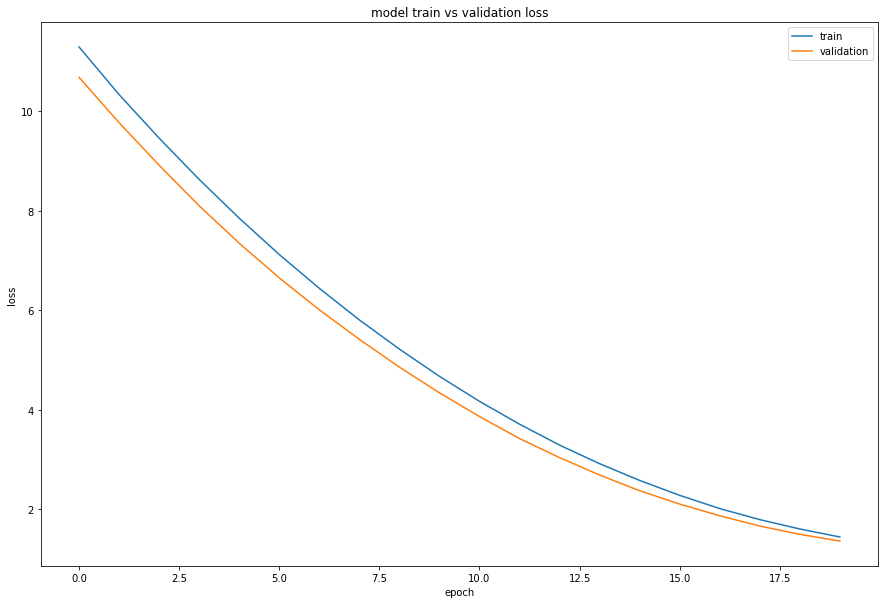

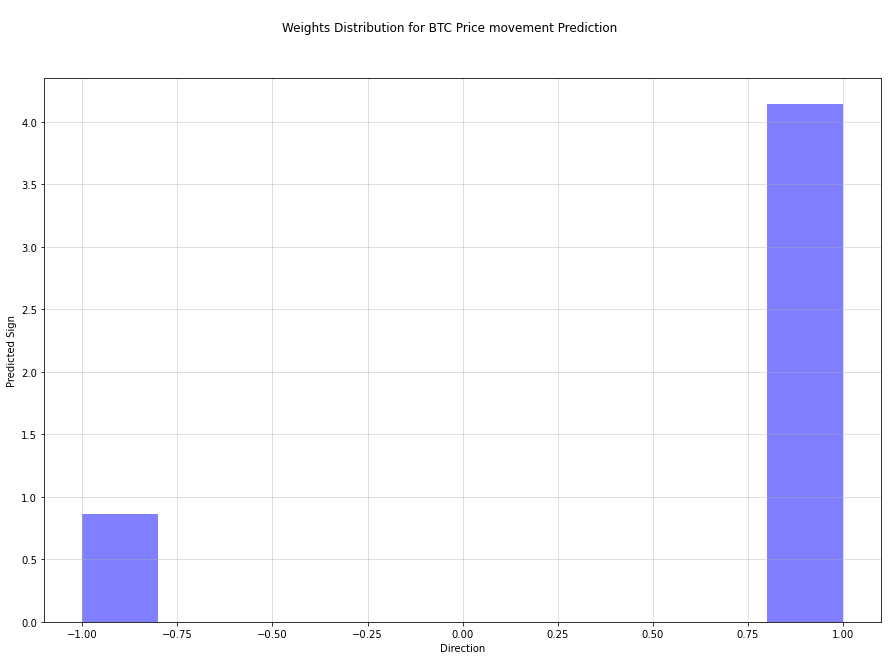


 Results Analysis 



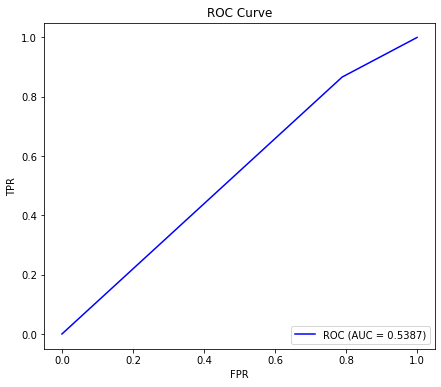

+----------------+----------+
| Metric         |   Values |
|----------------+----------|
| Accuracy       | 0.538967 |
| F1 Score       | 0.538686 |
| Area Under ROC | 0.652912 |
+----------------+----------+

 Confusion matrix
+---------------+------------------+-----------------+
|               |   Pred. Negative |   Pred Positive |
|---------------+------------------+-----------------|
| True Negative |              369 |            1381 |
| True Positive |              234 |            1519 |
+---------------+------------------+-----------------+




In [ ]:
train_predict,valid_predict, test_predict, trainY, validY, testY, 
dates,trainY_raw, validY_raw, testY_raw = results_plotter('BTC','CNN_LSTM')


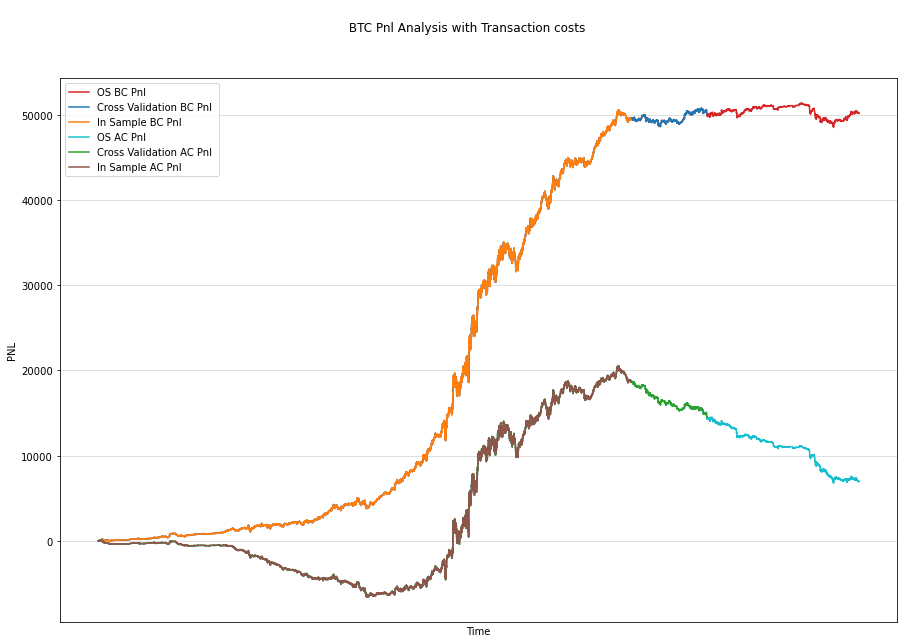

In [ ]:
is_bc, valid_bc, os_bc, is_ac, valid_ac, os_ac = TC_modeller(trainY_raw, validY_raw, 
                                                             testY_raw, train_predict, valid_predict, test_predict, 
                                                             dates,tc_coeff = 5, book_size = 1, switch = True)


## Base Model: CNN-LSTM with Open Price Data & Thresholds <a class="anchor" id="tsd"></a>

[Back to Top](#toc)


Model Architecture 

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_426 (TimeDi (None, None, 2, 32)       96        
_________________________________________________________________
time_distributed_427 (TimeDi (None, None, 2, 32)       0         
_________________________________________________________________
time_distributed_428 (TimeDi (None, None, 1, 64)       4160      
_________________________________________________________________
time_distributed_429 (TimeDi (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_430 (TimeDi (None, None, 64)          0         
_________________________________________________________________
lstm_96 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dense_104 (Dense)            (

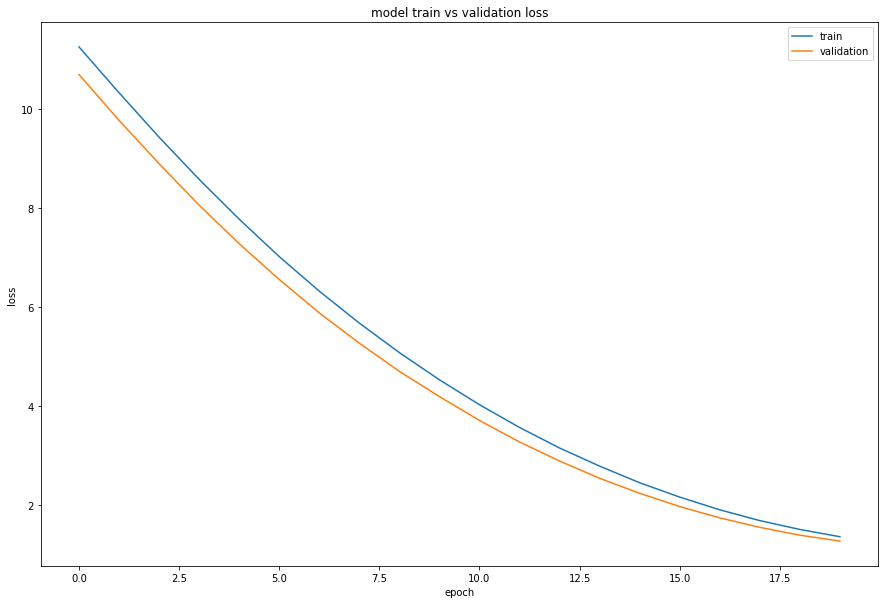

(3503, 1) (3503,) (3503,)
(401,) (401,) (401,)
(1751, 1) (1751,) (1751,)
(1751, 1) (1751,) (1751,)
(12259, 1) (12259,) (12259,)
(12259, 1) (12259,) (12259,)


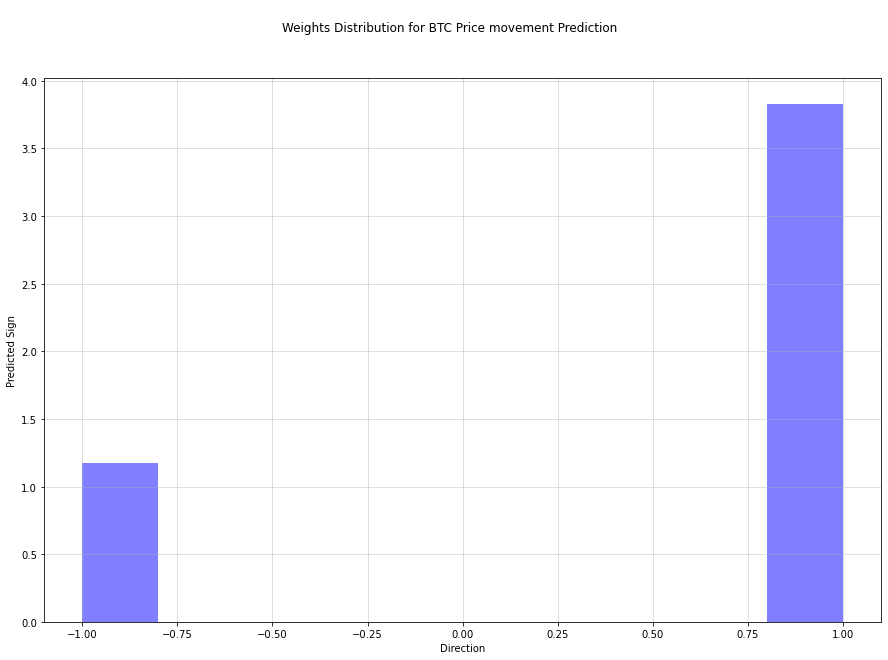


 Results Analysis 



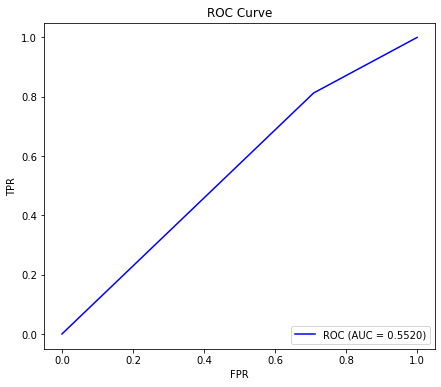

+----------------+----------+
| Metric         |   Values |
|----------------+----------|
| Accuracy       | 0.57606  |
| F1 Score       | 0.551997 |
| Area Under ROC | 0.676806 |
+----------------+----------+

 Confusion matrix
+---------------+------------------+-----------------+
|               |   Pred. Negative |   Pred Positive |
|---------------+------------------+-----------------|
| True Negative |               53 |             129 |
| True Positive |               41 |             178 |
+---------------+------------------+-----------------+




In [ ]:
train_predict,valid_predict, test_predict, trainY, validY, testY, dates,trainY_raw, 
validY_raw, testY_raw = results_plotter('BTC','CNN_LSTM', True, 0.99)

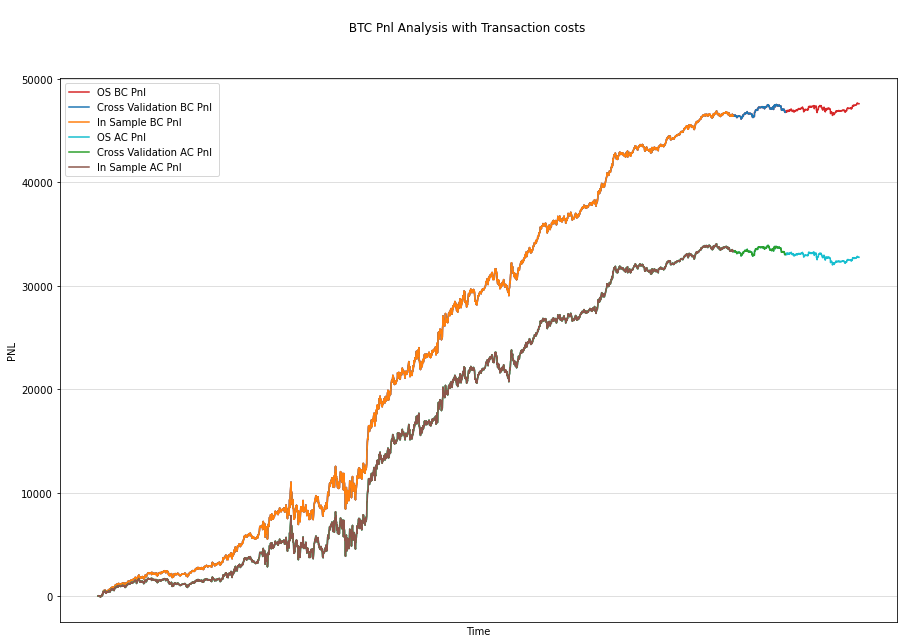

In [ ]:
is_bc, valid_bc, os_bc, is_ac, valid_ac, os_ac = TC_modeller(trainY_raw, validY_raw, 
                                                             testY_raw, train_predict, valid_predict, 
                                                             test_predict, dates,tc_coeff = 5, book_size = 1)


## Base Model: Hyperparameter Tuning <a class="anchor" id="ht"></a>

[Back to Top](#toc)

In [ ]:
bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]


Model Architecture 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 2, 64)       192       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1, 64)       8256      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                23000     
_________________________________________________________________
dense (Dense)                (None


Model Architecture 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 2, 64)       192       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1, 64)       8256      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                23000     
_________________________________________________________________
dense (Dense)                (None


Model Architecture 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 2, 64)       192       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1, 64)       8256      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                23000     
_________________________________________________________________
dense (Dense)                (None

INFO:tensorflow:Oracle triggered exit

Model Architecture 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 2, 64)       192       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1, 64)       8256      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                23000     
______________________________________________________________

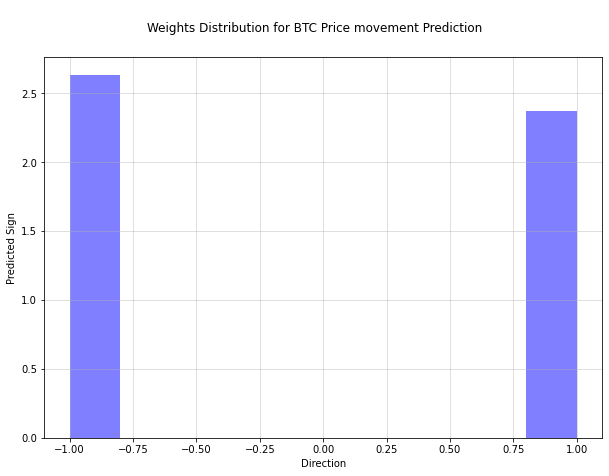


 Results Analysis 



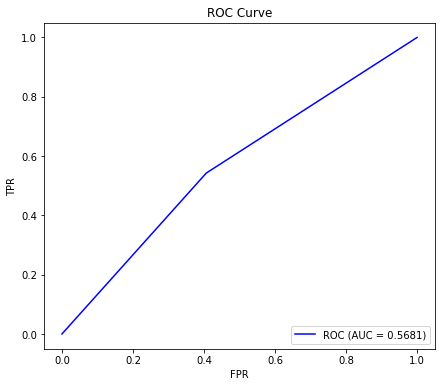

+----------------+----------+
| Metric         |   Values |
|----------------+----------|
| Accuracy       | 0.56837  |
| F1 Score       | 0.568116 |
| Area Under ROC | 0.554508 |
+----------------+----------+

 Confusion matrix
+---------------+------------------+-----------------+
|               |   Pred. Positive |   Pred Negative |
|---------------+------------------+-----------------|
| True Positive |             1050 |             719 |
| True Negative |              793 |             941 |
+---------------+------------------+-----------------+




In [ ]:
results_plotter_bayes(model)

## Base Model: More Layers <a class="anchor" id="layers"></a>

[Back to Top](#toc)

We also attempted adding more LSTM layers, since multiple literature sources suggest empirical performance improvement when we add more layers in RNN architecture. Here we added two LSTM layers following the initial LSTM (50)


Model Architecture 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 3, 32)       96        
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 3, 32)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 2, 64)       4160      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
lstm_7 (LSTM)                (No

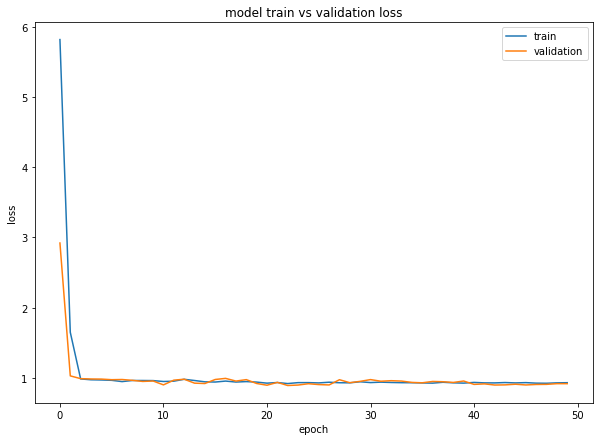

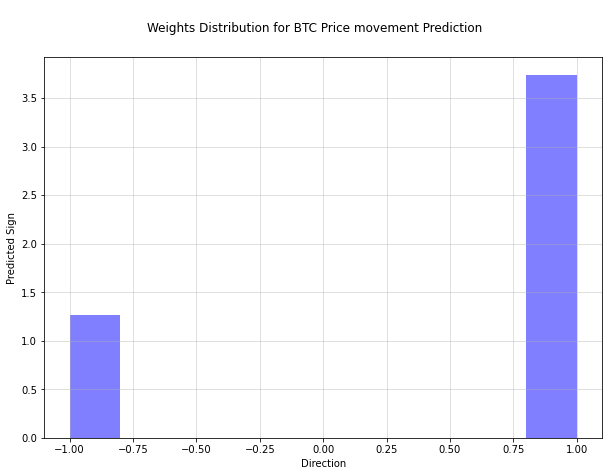


 Results Analysis 



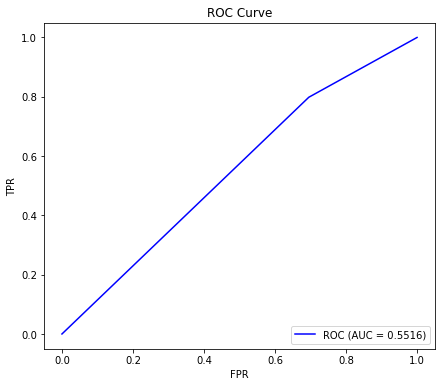

+----------------+----------+
| Metric         |   Values |
|----------------+----------|
| Accuracy       | 0.551527 |
| F1 Score       | 0.551598 |
| Area Under ROC | 0.640256 |
+----------------+----------+

 Confusion matrix
+---------------+------------------+-----------------+
|               |   Pred. Positive |   Pred Negative |
|---------------+------------------+-----------------|
| True Positive |              534 |            1218 |
| True Negative |              353 |            1398 |
+---------------+------------------+-----------------+




In [ ]:
results_plotter('BTC','CNN_LSTM')

## Base Model: Rolling Horizon <a class="anchor" id="rh"></a>

[Back to Top](#toc)

In [ ]:
split_rng = [0.4, 0.5, 0.6, 0.7, 0.8]
def rolling_train(split, plot = False):
    testPredict, model, testY = model_trainer('btc', 'CNN_LSTM', split)
    
    if plot:
        fig, axs = plt.subplots(1)
        fig.suptitle('\nWeights Distribution for {} Price movement Prediction'.format(coin))
        n, bins, patches = axs.hist(testPredict, 10, density=True, facecolor='b', alpha=0.5)
        axs.set_ylabel('Predicted Sign')
        axs.set_xlabel('Direction')

        axes = plt.gca()

        plt.grid(True, alpha=0.5)
        plt.rcParams["figure.figsize"] = (10,7)
        plt.show()

    #Results Analysis
    CM, Accuracy, F1, AUC,tpr, fpr = ClassificationEvaluation(testY, testPredict, True)
    return Accuracy,AUC,F1

comparison = {}
for s in split_rng:
    print(f"At {(s+0.1)*100}% / {(1-s-0.1)*100}% train/test split\n")
    Accuracy,AUC,F1 = rolling_train(s)
    comparison[s] = [Accuracy,AUC,F1]

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format

#Accuracy,AUC,F1
comparison_df = pd.DataFrame(comparison, 
                            index = ['Accuracy','AUC','F1']).T
comparison_df.index = [f'{s*10}/{(10-s)*10}%' for s in range(5,10)]
print('Train/Test % Comparison (10% Validation Incl. in Train)\n')
comparison_df

Train/Test % Comparison (10% Validation Incl. in Train)



,Accuracy,AUC,F1
50/50%,0.5386,0.5402,0.6439
60/40%,0.5546,0.5564,0.6374
70/30%,0.5431,0.5437,0.6496
80/20%,0.5452,0.5453,0.6448
90/10%,0.5597,0.5625,0.6177


## Advanced Model - External Data <a class="anchor" id="ed"></a>

[Back to Top](#toc)

As we saw below, we found out that the BTC has some relation (negative or positive) with some financial<br>
time series. For example, we observe that it is negatively correlated with the USD, that why we can <br>
feed our model with the three majors pairs in order to feed our model with the USD dynamic.<br>

Also, we have constructed some technical features such as the realize volatility, the RSI and <br>
Bollinger Bands in order to capture the market dynamic <br>

Here we will use the function results_plotter_multi which will take into account this set of features<br>
to get better prediction of the BTC evolution on the next hour. <br>

We have:<br>
- Differentiated features:<br>
> - Volume and Realized Volatility on the last 4 hours on BTC
> - 3 Currency Pairs: USD/JPY, EUR/UDS, GBP/USD
> - 2 Commodities: WTI and Gold
> - VIX
- No Differentiated features but normalized:<br>
> - RSI
> - Stochastic Oscillator
> - Bollinger Band

(12258, 4, 13)
(12258, 1, 4, 13)

Model Architecture 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, None, 3, 32)       864       
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 3, 32)       0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 2, 64)       4160      
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                35800     
_________________________________________________________________

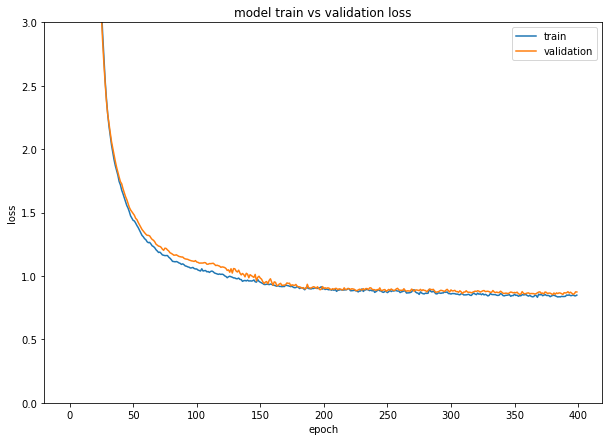

(3503, 1) (3503,) (3503,)
(1523,) (1523,) (1523,)
(1751, 1) (1751,) (1751,)
(1751, 1) (1751,) (1751,)
(12258, 1) (12258,) (12258,)
(12258, 1) (12258,) (12258,)


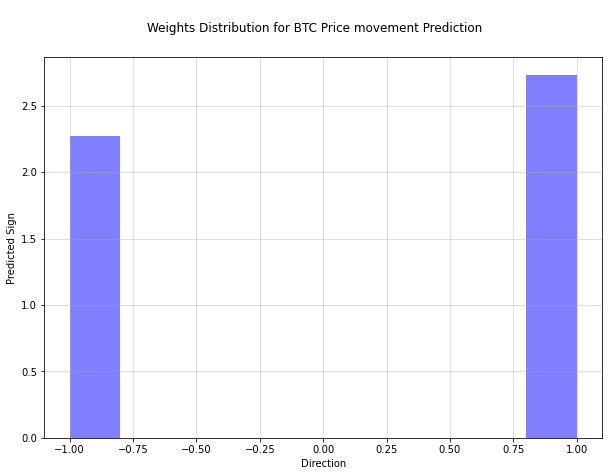


 Results Analysis 



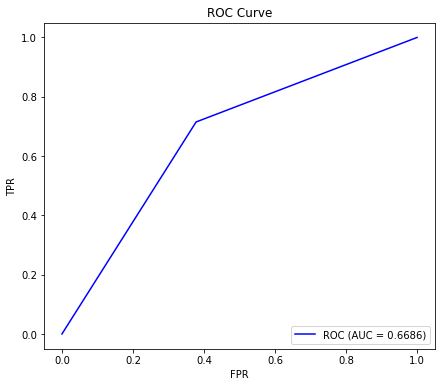

+----------------+----------+
| Metric         |   Values |
|----------------+----------|
| Accuracy       | 0.668418 |
| F1 Score       | 0.668631 |
| Area Under ROC | 0.68219  |
+----------------+----------+

 Confusion matrix
+---------------+------------------+-----------------+
|               |   Pred. Negative |   Pred Positive |
|---------------+------------------+-----------------|
| True Negative |              476 |             289 |
| True Positive |              216 |             542 |
+---------------+------------------+-----------------+




In [ ]:
train_predict,valid_predict, test_predict, trainY, validY, testY, dates, \
trainY_raw, validY_raw, testY_raw = results_plotter_multi('BTC','CNN_LSTM', True, 0.99)

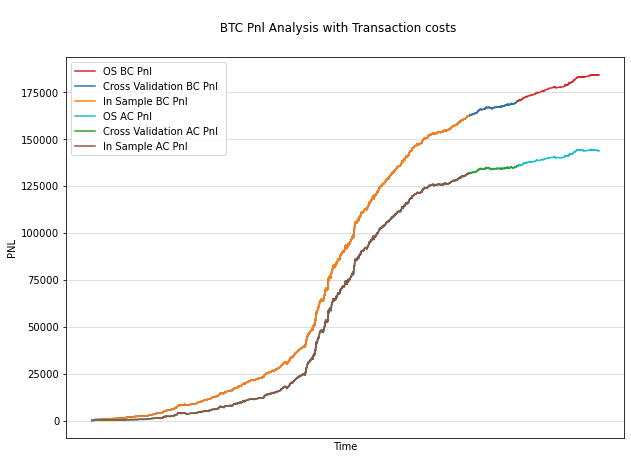

In [ ]:
is_bc, valid_bc, os_bc, is_ac, valid_ac, os_ac = TC_modeller(trainY_raw, validY_raw, testY_raw, train_predict, valid_predict, test_predict, dates,tc_coeff = 5, book_size = 1)
